In [1]:
!pip install faiss-cpu catboost

In [211]:
import faiss

import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# Load data

In [3]:
df_base = pd.read_csv('../Master_room2/data/base.csv', index_col=0)
df_train = pd.read_csv('../Master_room2/data/target.csv', index_col=0)
df_validation = pd.read_csv('../Master_room2/data/validation.csv', index_col=0)
df_validation_answer = pd.read_csv('../Master_room2/data/validation_answer.csv', index_col=0)

In [4]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [5]:
df_train.shape

(100000, 73)

In [6]:
targets = df_train['Target']
df_train.drop(columns=['Target'], inplace=True)

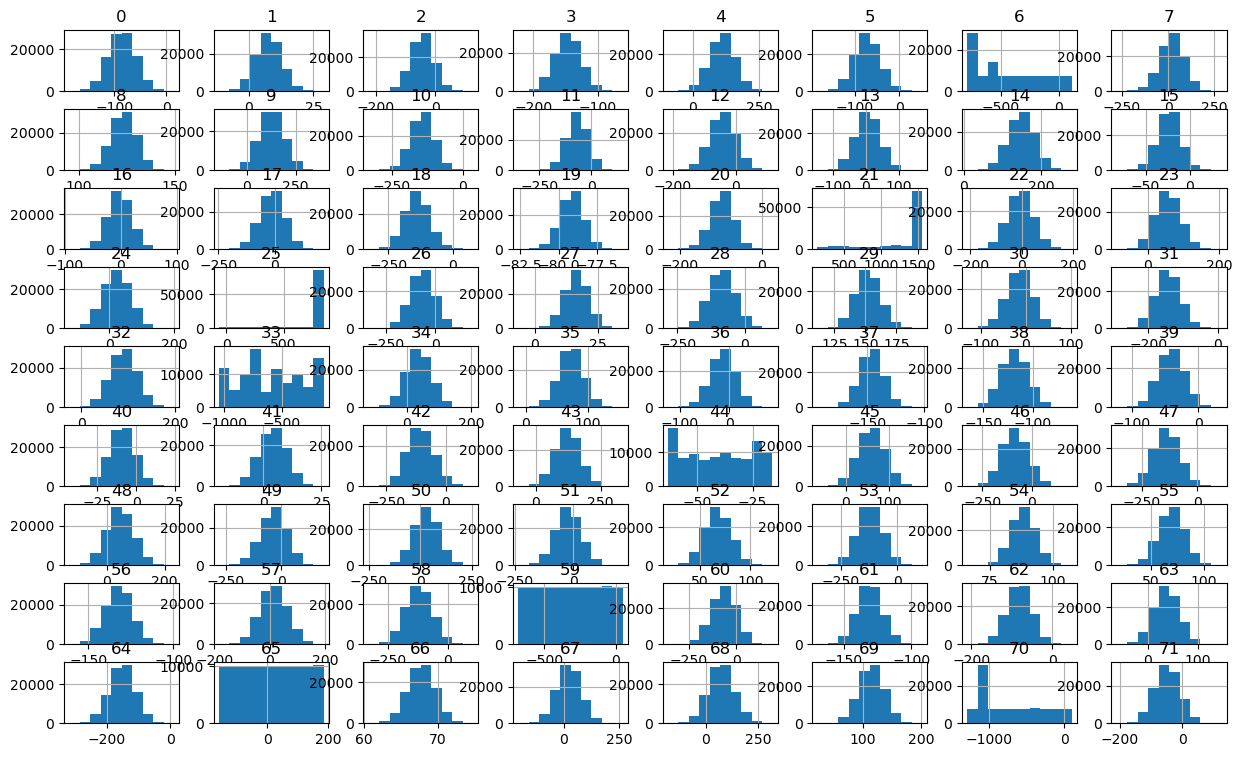

In [7]:
df_train.hist(bins=10, figsize=(15, 9));

### Create index

In [8]:
#count of Index, d=dimensions
d = df_base.shape[1]
#claster count
n_cells = 36
#call Index type with L2 (Eucledian distance) with "d" dimension
quantizer = faiss.IndexFlatL2(d)
#
idx_l2 = faiss.IndexIVFFlat(quantizer, d, n_cells)

In [9]:
#train vectors for creating clusters
idx_l2.train(np.ascontiguousarray(df_base.values[:, :]).astype('float32'))

In [10]:
#check if model is trained
idx_l2.is_trained

True

In [11]:
#drop indexes into field of Voronoi space
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

### Search for K-nearest neighbors

In [12]:
#number of required neighbors
k = 100

In [13]:
#how many clasters(cells) will be used for search
idx_l2.nprobe = 20

In [14]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)

CPU times: total: 3h 15min 14s
Wall time: 25min 53s


In [15]:
#creating a dict for indexes
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [16]:
#accuracy
acc = 0

for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100* acc / len(idx))

17.829


In [146]:
idx.shape

(100000, 100)

In [147]:
idx

array([[1480698,  161948, 1076334, ..., 1925889,  683928, 1447856],
       [ 445586,  920175, 2168908, ..., 1713682, 2183201, 2120879],
       [1659033,  760940,  656828, ..., 1123704,  456836, 1961245],
       ...,
       [2690258,  700937, 1242425, ..., 2274259,  241051, 1869141],
       [1197717, 2500439, 2265191, ..., 1220716, 1052388,  141460],
       [1958647,  272735,  458565, ..., 1226406,  583213,  378929]],
      dtype=int64)

In [195]:
#change to DataFrame type, just for simplify
df_idx = pd.DataFrame(idx)

In [196]:
df_idx = df_idx.iloc[:, :100]

In [149]:
df_idx.sample()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
5638,247710,1613353,1037619,206696,2876220,565870,2581646,733719,1107211,2088769,...,1188639,2505810,2904484,2498112,710161,2134623,1066510,2607347,2814829,274492


### Preparing Target dataset

In [174]:
#rename column
targets.name = 'base_name'

In [184]:
#creating new column for searching and comparing
targets = targets.reset_index()
targets.head()

,Id,base_name
0,0-query,675816-base
1,1-query,366656-base
2,2-query,1447819-base
3,3-query,1472602-base
4,4-query,717819-base


In [187]:
#adding index for related name of base_name line in df_base
targets['base_index'] = [df_base.index.get_loc(name) for name in targets['base_name']]

In [188]:
targets.head()

,Id,base_name,base_index
0,0-query,675816-base,598613
1,1-query,366656-base,341406
2,2-query,1447819-base,1162532
3,3-query,1472602-base,1179186
4,4-query,717819-base,631912


### Creating new dataset of features for next predictions

In [151]:
#creating a new list with 144 features, with correlated 'query' vector and 'base' vector
#in 2nd cycle 'for' you might change count of knn ([:10]) for next modeling
%%time
new_df = []
for i, row in df_idx.iterrows():
    train_line = df_train.iloc[i, :].copy()
    for el in row[:10]:
        combined_row = pd.concat([train_line, df_base.iloc[el,:]], axis=0, ignore_index=True)
        new_df.append(combined_row)


CPU times: total: 3min 16s
Wall time: 3min 16s


In [155]:
%%time
#change type to pd.DataFrame, for simplify work
new_df = pd.DataFrame(new_df)

CPU times: total: 0 ns
Wall time: 1.99 ms


In [154]:
new_df.shape

(1000000, 144)

In [157]:
new_df.sample()

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
169999,-95.568436,5.848045,-33.384964,-135.99408,157.5545,-99.63469,-167.107564,187.00198,110.85147,135.60852,...,-34.089363,1.435894,-116.818016,-4.27137,70.32545,-38.781143,28.125076,123.12337,69.018969,-121.8945


In [199]:
#multiplying '0-query', '1-query' 10 times (beacuse took 10 knn for FAISS)
repeated_indices = np.repeat( df_train.index.tolist(), 10) 
#adding new column with 'queries'
new_df['index_from_df_train'] = repeated_indices[:len(new_df)]

In [212]:
#adding base_index to df, because idx are list of lists, using chain.from_iterable
new_df['base_index'] = list(chain.from_iterable(df_idx.loc[:, :9].values.tolist()))

In [221]:
#adding new target for next model
new_df['new_target'] = np.where(
    ((new_df['index_from_df_train'].values == targets['Id'].values) & (new_df['base_index'].values == targets['base_index'].values)),
    1,
    0
)

C:\Users\Vasilii\AppData\Local\Temp\ipykernel_12328\3304530331.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ((new_df['index_from_df_train'].values == targets['Id'].values) & (new_df['base_index'].values == targets['base_index'].values)), 1, 0)


In [224]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,index_from_df_train,base_index,new_target
0,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,-142.179746,68.043070,45.451233,94.673775,87.458496,-499.761047,-35.091328,0-query,1480698,0
1,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,-129.261362,68.919860,91.192120,110.904330,125.881030,-366.508894,-53.070760,0-query,161948,0
2,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,36.156667,67.159940,85.671130,69.763115,128.357040,-308.115944,-53.935226,0-query,1076334,0
3,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,-51.306075,67.306046,-2.194824,75.213410,144.907260,-546.084658,-84.147050,0-query,1882633,0
4,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,-111.820343,69.182434,-33.080030,49.920914,76.084885,-359.877415,31.329930,0-query,1282393,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-89.048460,10.938594,-53.206207,-144.18858,143.44533,-86.68419,-79.986290,77.225540,117.94943,73.297440,...,-144.574095,68.832670,-13.681173,67.930880,103.296555,-57.329750,-66.347500,99999-query,1499488,0
999996,-89.048460,10.938594,-53.206207,-144.18858,143.44533,-86.68419,-79.986290,77.225540,117.94943,73.297440,...,-74.916139,67.944860,75.384270,128.464600,138.163040,11.107604,-79.000980,99999-query,1831967,0
999997,-89.048460,10.938594,-53.206207,-144.18858,143.44533,-86.68419,-79.986290,77.225540,117.94943,73.297440,...,-20.492306,66.089714,-14.579290,136.806580,136.402470,71.325172,-57.141823,99999-query,1934483,0
999998,-89.048460,10.938594,-53.206207,-144.18858,143.44533,-86.68419,-79.986290,77.225540,117.94943,73.297440,...,-38.924965,69.922450,8.233225,70.862656,82.222380,12.653885,-80.160230,99999-query,641628,0


In [226]:
new_df[new_df['new_target']==1]

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,index_from_df_train,base_index,new_target


Строка выше показывает что алгоритм не нашёл соответствия между полученными knn и указанным target'ом в исходном датасете для обучения.

## NEED HELP! :(

Во-первых: если я правильно понимаю, accuracy после применения faiss показал на моих расчетах 17%, при этом у меня в текущем новом датафрейме 0 совпадений, видимо я что-то не так сделал для получения нового датасета.

Во-вторых: мастабирование данных - пробовал MinMaxScaler(), но тогда accuracy для faiss падал до 0%.

В-третьих: Далее алгоритм понятен
* Разделить датасет на train/valid/test
* Применить GridSearchCV для разных моделей CatBoost
* Высчитать predict_proba и взять топ лучших ответов для подсчета accuracy@5


Но борьба с faiss'ом и датасетом довела до того, что глаза замылились:(


Прошу дать комментарии/советы по вышестоящим вопросам, что улучшить